In [13]:
import torch 
import numpy as np 
import torchvision 
import torch.nn.functional as F

import pandas as pd 
import numpy as np

from torch import nn , optim

from torchvision import datasets , models , transforms 

from torch.utils.data import DataLoader 

from torch.utils import data 
from torch.utils.data import Dataset

from collections import OrderedDict
from PIL import Image

import matplotlib.pyplot as plt 

import requests
from io import BytesIO

import time 

import multiprocessing 

import pickle

import tqdm

In [14]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [15]:
class UNet(nn.Module):
    
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        
        return torch.sigmoid(x)

In [16]:
model = UNet(1,1)

In [38]:
device  ="cuda"

model.to(device)

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-0

Creating a Data Loader 

In [39]:
import glob

img_noisy_names = []

for i in glob.glob("train/*.png"):
    img_noisy_names.append(i)
    
print(len(img_noisy_names))

144


In [40]:
img_names = []

for i in glob.glob("train_cleaned/*.png"):
    img_names.append(i)
    
print(len(img_names))

144


In [41]:
from sklearn.model_selection import train_test_split 

Xtrain , Xtest , Ytrain , Ytest  = train_test_split(img_noisy_names , img_names , test_size = 0.2 , random_state = 2)

In [42]:
print(len(Xtrain))
print(len(Xtest))
print(len(Ytrain))
print(len(Ytest))

115
29
115
29


In [43]:
class Dataset(data.Dataset):
    def __init__(self, img_noisy_names , img_names , transform=None):
        self.noisy = img_noisy_names
        self.img = img_names
        self.transform = transform

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, index):
        X = Image.open(self.noisy[index])
        Y = Image.open(self.img[index])
        
        if self.transform:
            X = self.transform(X)
            Y = self.transform(Y)

        return X , Y

In [44]:
data_transforms = {
    
    'train' : transforms.Compose([transforms.Resize((320,480)),
                                 transforms.ToTensor(),
                                 ]),
    
    'test' : transforms.Compose([transforms.Resize((320,480)),
                                 transforms.ToTensor(),
                                ])
}

In [45]:
training_data = Dataset( Xtrain , Ytrain , transform = data_transforms['train'])
testing_data = Dataset( Xtest , Ytest  ,transform = data_transforms['test'])

In [46]:
data_loader = {
    
    'train' : DataLoader(training_data, batch_size = 4 , shuffle = True) , 
    
    'test' : DataLoader( testing_data , batch_size = 4 , shuffle = False)
    
}

(4, 1, 320, 480)
(4, 320, 480, 1)
(320, 480, 1)


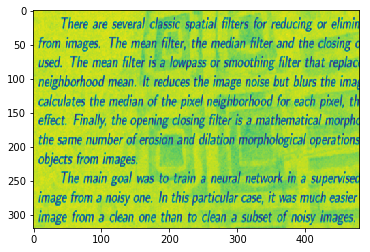

In [47]:
images , labels = next(iter(data_loader['train']))

images = images.numpy()

print(images.shape)

images = images.transpose(0,2,3,1)

print(images.shape)

img = images[0]

print(img.shape)

img = img.clip(0,1)

plt.imshow(img.reshape(320,480))

In [48]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
n_epochs = 20

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    

    for data in data_loader['train']:

        noisy_imgs, images = data
        
        images = images.cuda()
        noisy_imgs = noisy_imgs.cuda()

        optimizer.zero_grad()

        outputs = model(noisy_imgs)

        loss = criterion(outputs, images)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()*images.size(0)
            
    train_loss = train_loss/len(data_loader['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format( epoch, train_loss))

/opt/DL/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/opt/DL/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.371825
Epoch: 2 	Training Loss: 0.161482
Epoch: 3 	Training Loss: 0.077598
Epoch: 4 	Training Loss: 0.041387
Epoch: 5 	Training Loss: 0.024870
Epoch: 6 	Training Loss: 0.016988
Epoch: 7 	Training Loss: 0.012283
Epoch: 8 	Training Loss: 0.009524
Epoch: 9 	Training Loss: 0.007922
Epoch: 10 	Training Loss: 0.006419
Epoch: 11 	Training Loss: 0.005953
Epoch: 12 	Training Loss: 0.005124
Epoch: 13 	Training Loss: 0.004760
Epoch: 14 	Training Loss: 0.004743
Epoch: 15 	Training Loss: 0.004275
Epoch: 16 	Training Loss: 0.003493
Epoch: 17 	Training Loss: 0.003260
Epoch: 18 	Training Loss: 0.003327
Epoch: 19 	Training Loss: 0.003226
Epoch: 20 	Training Loss: 0.002979


In [50]:
torch.save(model.state_dict() , "weights.pth")

In [17]:
model.to("cpu")

model.load_state_dict(torch.load("weights.pth"))

from PIL import Image

def load_image(img_path):
    
    image = Image.open(img_path)
        
    in_transform = transforms.Compose([transforms.Resize((320,480)),
                                       transforms.ToTensor(),])
    
    image = in_transform(image)[:1,:,:].unsqueeze(0)
    
    return image

/opt/DL/pytorch/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


torch.Size([1, 1, 320, 480])
(320, 480, 1)


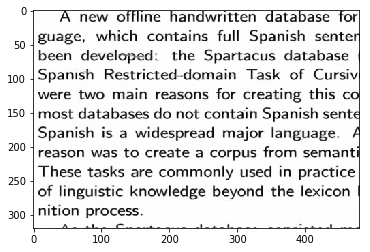

In [12]:
image = load_image("test/118.png")

with torch.no_grad():
    model.eval()
    output = model(image)
    print(output.shape)
    
output = output.numpy()
    
output = output.transpose(0,2,3,1)

img = output[0]

print(img.shape)

img = img.clip(0,1)

plt.imshow(img.reshape(320,480) , cmap = "gray")